In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("./electricity_train.csv")

target = df.columns[-1]

share_class_1 = round((df[target] == 1).mean(), 3)

corr = df.drop(columns=[target]).corr().abs()
np.fill_diagonal(corr.values, 0)
max_pair = tuple(sorted(corr.stack().idxmax()))

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

rf = RandomForestClassifier(random_state=21)
rf.fit(X_train, y_train)
rf_train_acc = round(accuracy_score(y_train, rf.predict(X_train)), 3)

params_grid = {
    "n_estimators": [100, 300, 500],
    "max_leaf_nodes": list(range(6, 10)),
    "min_samples_leaf": [1, 2, 3]
}

grid = GridSearchCV(
    RandomForestClassifier(
        bootstrap=False,
        class_weight="balanced",
        n_jobs=-1,
        max_features="sqrt",
        random_state=21
    ),
    params_grid,
    cv=3,
    verbose=0
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_

best_train_acc = round(accuracy_score(y_train, best_model.predict(X_train)), 3)
best_test_acc = round(accuracy_score(y_test, best_model.predict(X_test)), 3)

most_important_feature = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).idxmax()

voting = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(solver="liblinear", random_state=21)),
        ("svc", SVC(random_state=21)),
        ("sgd", SGDClassifier(random_state=21))
    ],
    voting="hard"
)

voting.fit(X_train, y_train)
voting_acc = round(accuracy_score(y_test, voting.predict(X_test)), 3)

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(class_weight="balanced"),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=21
)

bagging.fit(X_train, y_train)
bagging_acc = round(accuracy_score(y_test, bagging.predict(X_test)), 3)

gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.8,
    max_depth=2,
    random_state=21
)

gb.fit(X_train, y_train)
gb_acc = round(accuracy_score(y_test, gb.predict(X_test)), 3)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=3,
        class_weight="balanced"
    ),
    n_estimators=300,
    learning_rate=0.5,
    random_state=21
)

ada.fit(X_train, y_train)
ada_acc = round(accuracy_score(y_test, ada.predict(X_test)), 3)

stack = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(random_state=21)),
        ("svc", SVC(random_state=21))
    ],
    final_estimator=LogisticRegression(random_state=21)
)

stack.fit(X_train, y_train)
stack_acc = round(accuracy_score(y_test, stack.predict(X_test)), 3)

(
    share_class_1,
    max_pair,
    rf_train_acc,
    best_params["max_leaf_nodes"],
    best_params["min_samples_leaf"],
    best_params["n_estimators"],
    best_train_acc,
    best_test_acc,
    most_important_feature,
    voting_acc,
    bagging_acc,
    gb_acc,
    ada_acc,
    stack_acc
)


(np.float64(0.425),
 ('nswdemand', 'vicdemand'),
 1.0,
 9,
 1,
 100,
 0.789,
 0.784,
 'nswprice',
 0.747,
 0.872,
 0.895,
 0.8,
 0.906)

<Figure size 1500x1000 with 0 Axes>

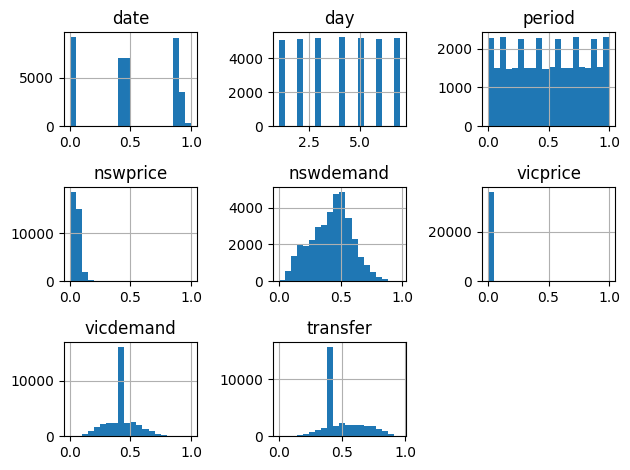

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("electricity_train.csv")

target = df.columns[-1]
features = df.drop(columns=[target])

plt.figure(figsize=(15, 10))
features.hist(bins=20, layout=(int(len(features.columns) / 3) + 1, 3))
plt.tight_layout()
plt.show()
